In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/My Drive/ProyectoIA2/generative-spectral-datasets')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
from models.main import make_autoencoder, make_discriminator

input_shape = (32,32,3)

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = train_images / 255

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
print(train_images.shape)

(50000, 32, 32, 3)


In [5]:
mse_loss = tf.keras.losses.MeanSquaredError()


def discriminator_loss(real_output, fake_output):
    loss = tf.math.log(real_output) + tf.math.log(1 - fake_output)
    return - tf.math.reduce_mean(loss)
    
def autoencoder_loss(real_x, estimated_x, real_output, fake_output, tau=0.001):
    autoencoder_loss = mse_loss(real_x, estimated_x)
    gan_loss =  tau*discriminator_loss(real_output, fake_output)
    total_loss = autoencoder_loss - gan_loss
    return total_loss

A_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

FACTOR = [ 1 , 1 , 1/16 , 1/32 , 1/64, 1/256]
features= 256

A = make_autoencoder(input_shape, features=features, factors=FACTOR)

D = make_discriminator(input_shape, features=features, factors=FACTOR)
# discriminator = tf.keras.applications.mobilenet.MobileNet(input_shape=input_shape, classes=1, weights=None, classifier_activation='sigmoid')



In [6]:
A.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Encoder)            (None, 32, 32, 1)         637781    
_________________________________________________________________
generator (Generator)        (None, 32, 32, 3)         637779    
Total params: 1,275,560
Trainable params: 1,273,398
Non-trainable params: 2,162
_________________________________________________________________


In [7]:
D.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
discriminator (Discriminator (None, 32, 32, 1)         637791    
Total params: 637,791
Trainable params: 636,709
Non-trainable params: 1,082
_________________________________________________________________


In [8]:
@tf.function
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      # INFERENCE
      generated_images = A(images, training=True)
      real_output = D(images, training=True)
      fake_output = D(generated_images, training=True)

      # LOSS COMPUTING
      A_loss = autoencoder_loss(images, generated_images, real_output, fake_output)
      D_loss = discriminator_loss(real_output, fake_output)

      # BACKPROPAGATION
      A_gradients = gen_tape.gradient(A_loss, A.trainable_variables)
      D_gradients = disc_tape.gradient(D_loss, D.trainable_variables)

      A_optimizer.apply_gradients(zip(A_gradients, A.trainable_variables))
      D_optimizer.apply_gradients(zip(D_gradients, D.trainable_variables))

      return A_loss , D_loss


def train(dataset, epochs):
  print("START TRAINING")
  for epoch in range(epochs):

    ae_total_loss = []
    disc_total_loss = []

    for image_batch in dataset:
      gen_loss , disc_loss = train_step(image_batch)

      ae_total_loss.append(float(gen_loss))
      disc_total_loss.append(float(disc_loss))
      print("Autoencoder loss: %.4f | Discriminator loss: %.4f" % (float(gen_loss), float(disc_loss))) 

    ae_total_loss = np.mean(ae_total_loss)
    disc_total_loss = np.mean(disc_total_loss)

    print("TOTAL: Autoencoder loss: %.4f | Discriminator loss: %.4f" % (float(ae_total_loss), float(disc_total_loss))) 

  print("END TRAINING")


In [9]:
EPOCHS = 10
train(train_dataset, EPOCHS)

START TRAINING
Autoencoder loss: 0.7057 | Discriminator loss: 1.5957
Autoencoder loss: 0.5435 | Discriminator loss: 1.5577
Autoencoder loss: 0.4357 | Discriminator loss: 1.5334
Autoencoder loss: 0.4021 | Discriminator loss: 1.5162
Autoencoder loss: 0.3495 | Discriminator loss: 1.4973
Autoencoder loss: 0.3284 | Discriminator loss: 1.4845
Autoencoder loss: 0.3072 | Discriminator loss: 1.4740
Autoencoder loss: 0.2796 | Discriminator loss: 1.4648
Autoencoder loss: 0.2539 | Discriminator loss: 1.4578
Autoencoder loss: 0.2448 | Discriminator loss: 1.4494
Autoencoder loss: 0.2331 | Discriminator loss: 1.4441
Autoencoder loss: 0.2135 | Discriminator loss: 1.4446
Autoencoder loss: 0.2030 | Discriminator loss: 1.4450
Autoencoder loss: 0.1965 | Discriminator loss: 1.4371
Autoencoder loss: 0.1810 | Discriminator loss: 1.4310
Autoencoder loss: 0.1714 | Discriminator loss: 1.4268
Autoencoder loss: 0.1688 | Discriminator loss: 1.4261
Autoencoder loss: 0.1580 | Discriminator loss: 1.4260
Autoencoder l

In [12]:
x = next(iter(train_dataset))

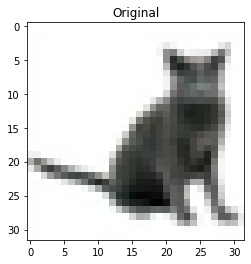

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


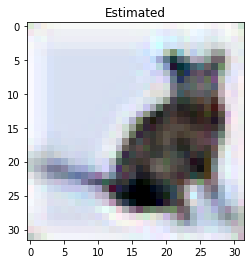

In [13]:
x_estimated = A.predict(x)

import matplotlib.pyplot as plt

num = np.random.randint(0, x.shape[0])

plt.title("Original")
plt.imshow(x[num,:,:])
plt.show()

plt.title("Estimated")
plt.imshow(x_estimated[num,:,:])
plt.show()